In [26]:
import pandas as pd
import re
import numpy as np

# Read CSV
panel_df = pd.read_csv("data/panel_data.csv")



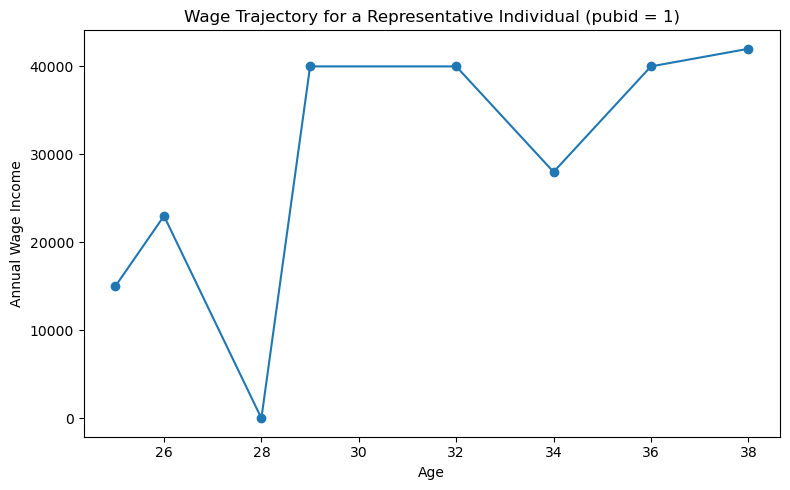

In [28]:
import matplotlib.pyplot as plt

person1 = df[df["pubid"] == 100].copy()

plt.figure(figsize=(8,5))
plt.plot(person1["age"], person1["income_wages"], marker="o")
plt.xlabel("Age")
plt.ylabel("Annual Wage Income")
plt.title("Wage Trajectory for a Representative Individual (pubid = 1)")
plt.tight_layout()
plt.show()

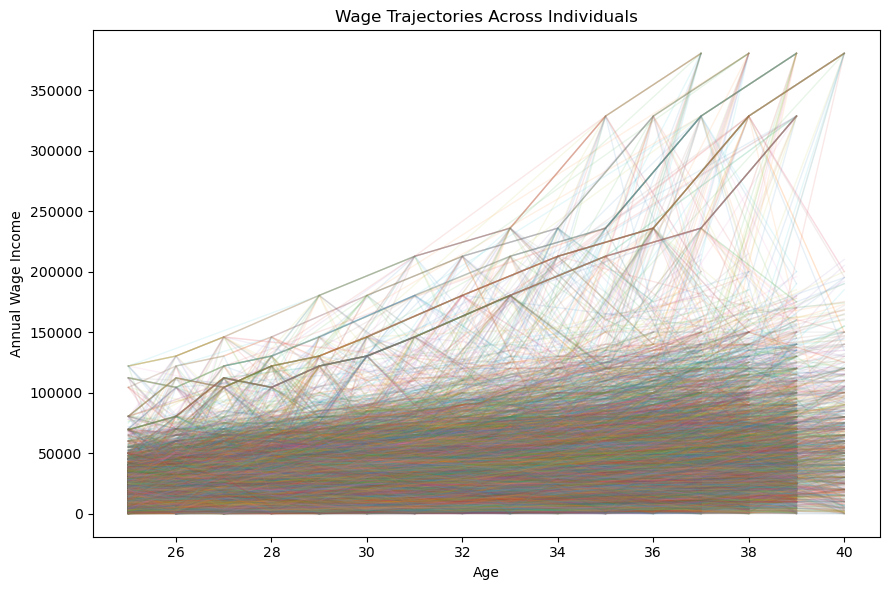

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))

for pid, sub in df.groupby("pubid"):
    plt.plot(
        sub["age"],
        sub["income_wages"],
        alpha=0.1,       # transparency is key
        linewidth=1
    )

plt.xlabel("Age")
plt.ylabel("Annual Wage Income")
plt.title("Wage Trajectories Across Individuals")
plt.tight_layout()
plt.show()

In [24]:
panel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197648 entries, 0 to 197647
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   pubid                       197648 non-null  int64  
 1   sex                         197648 non-null  int64  
 2   key!bdate_y                 197648 non-null  int64  
 3   cv_hh_income_source         197648 non-null  int64  
 4   cvc_hgc_ever                195448 non-null  float64
 5   cvc_highest_degree_ever     196944 non-null  float64
 6   cvc_ged                     25168 non-null   float64
 7   cvc_hs_diploma              148588 non-null  float64
 8   cvc_aa_degree               26070 non-null   float64
 9   cvc_ba_degree               52536 non-null   float64
 10  cvc_prof_degree             2816 non-null    float64
 11  cvc_phd_degree              1430 non-null    float64
 12  cvc_ma_degree               15774 non-null   float64
 13  cvc_hs_left_da

In [25]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# =====================================================
# 0) Copy data
# =====================================================
dfm = panel_df.copy()

# =====================================================
# 1) Clean missing codes: negative numeric values -> NaN
# =====================================================
num_cols = dfm.select_dtypes(
    include=["int64", "float64", "int32", "float32"]
).columns
dfm[num_cols] = dfm[num_cols].mask(dfm[num_cols] < 0)

# =====================================================
# 2) Outcome + sample restriction
# =====================================================
dfm = dfm[dfm["income_wages"].notna()].copy()
dfm["log_wage"] = np.log(dfm["income_wages"] + 1)

# Focus on adult wages
dfm = dfm[(dfm["age"] >= 25) & (dfm["age"] <= 40)].copy()

# =====================================================
# 3) Controls (LEAN + defensible)
# =====================================================
controls = [
    "sex",
    "race_black", "race_hispanic", "race_mixed",
    "age",
    "cv_hgc",                 # years of schooling
    "cv_census_region",
    "cv_msa",
    "urban_rural",
    "cv_hh_size",
]

controls = [c for c in controls if c in dfm.columns]



# =====================================================
# 4) Explicit regression sample (avoid silent row drops)
# =====================================================
vars_used = ["log_wage", "teen_move", "year"] + controls
dfm_reg = dfm[vars_used + ["pubid"]].dropna().copy()

print("Final regression N:", len(dfm_reg))

# =====================================================
# 5) Model A: OLS + year FE (robust SE)
# =====================================================
ols_formula = (
    "log_wage ~ teen_move + "
    + " + ".join(controls)
    + " + C(year)"
)

ols = smf.ols(
    ols_formula,
    data=dfm_reg
).fit(cov_type="HC1")

print("\n=== OLS (Year FE, robust SE) ===")
print(ols.summary())

# =====================================================
# 6) Model B: Two-way FE (pubid + year), clustered by pubid
# =====================================================
# NOTE: teen_move must vary within person for this to be identified
fe_formula = (
    "log_wage ~ teen_move + "
    + " + ".join([c for c in controls if c not in ["sex", "race_black", "race_hispanic", "race_mixed"]])
    + " + C(year) + C(pubid)"
)

fe = smf.ols(
    fe_formula,
    data=dfm_reg
).fit(
    cov_type="cluster",
    cov_kwds={"groups": dfm_reg["pubid"]}
)

print("\n=== Two-way FE (pubid + year FE, clustered by pubid) ===")
print(fe.summary())


Final regression N: 25109

=== OLS (Year FE, robust SE) ===
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     95.74
Date:                Fri, 12 Dec 2025   Prob (F-statistic):          2.76e-307
Time:                        13:29:45   Log-Likelihood:                -40068.
No. Observations:               25109   AIC:                         8.017e+04
Df Residuals:                   25092   BIC:                         8.031e+04
Df Model:                          16                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

c:\Users\benla\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 16
  warnings.warn('covariance of constraints does not have full '


LinAlgError: SVD did not converge

In [ ]:
dfm_reg["teen_move"].value_counts(normalize=True)


In [ ]:
dfm_reg.groupby("teen_move")["log_wage"].mean()


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# ----------------------------------
# 1) Prep data
# ----------------------------------
df = panel_df.copy()

# Clean negative NLSY codes
num_cols = df.select_dtypes(include=["int64","float64","int32","float32"]).columns
df[num_cols] = df[num_cols].mask(df[num_cols] < 0)

# Outcome
df = df[df["income_wages"].notna()].copy()
df["log_wage"] = np.log(df["income_wages"] + 1)

# Adult sample
df = df[(df["age"] >= 25) & (df["age"] <= 40)].copy()

# ----------------------------------
# 2) Minimal controls
# ----------------------------------
controls = [
    "sex",
    "race_black", "race_hispanic", "race_mixed",
    "age",
    "cv_hgc",          # education (years)
]

controls = [c for c in controls if c in df.columns]

vars_used = ["log_wage", "teen_move"] + controls
df_ols = df[vars_used].dropna().copy()

print("OLS sample size:", len(df_ols))

# ----------------------------------
# 3) Simple OLS
# ----------------------------------
ols_formula = "log_wage ~ teen_move + " + " + ".join(controls)

ols = smf.ols(
    ols_formula,
    data=df_ols
).fit(cov_type="HC1")

print("\n=== Simple OLS ===")
print(ols.summary())


OLS sample size: 25302

=== Simple OLS ===
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     191.1
Date:                Fri, 12 Dec 2025   Prob (F-statistic):          4.56e-239
Time:                        13:27:25   Log-Likelihood:                -40674.
No. Observations:               25302   AIC:                         8.136e+04
Df Residuals:                   25295   BIC:                         8.142e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Int

c:\Users\benla\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for tm, label in [(0, "No Teen Move"), (1, "Teen Move")]:
    sub = (
        g[g["teen_move"] == tm]
        .sort_values("age")
    )
    plt.plot(
        sub["age"],
        sub["log_wage"],
        marker="o",
        linewidth=2,
        label=label
    )

plt.xlabel("Age")
plt.ylabel("Average Log Wage")
plt.title("Adult Wage Profiles by Adolescent Migration Status")
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'teen_move'

<Figure size 800x500 with 0 Axes>

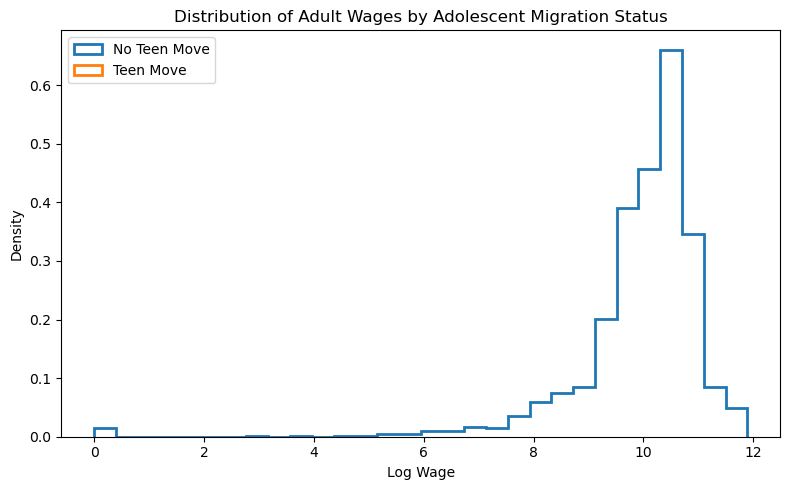

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.hist(
    df_ols[df_ols["move"] == 0]["log_wage"],
    bins=30,
    density=True,
    alpha=0.5,
    label="No Teen Move",
    edgecolor="black"
)

plt.hist(
    df_ols[df_ols["move"] == 1]["log_wage"],
    bins=30,
    density=True,
    alpha=0.5,
    label="Teen Move",
    edgecolor="black"
)

plt.xlabel("Log Wage")
plt.ylabel("Density")
plt.title("Distribution of Adult Wages by Adolescent Migration Status")
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'move'

<Figure size 800x500 with 0 Axes>

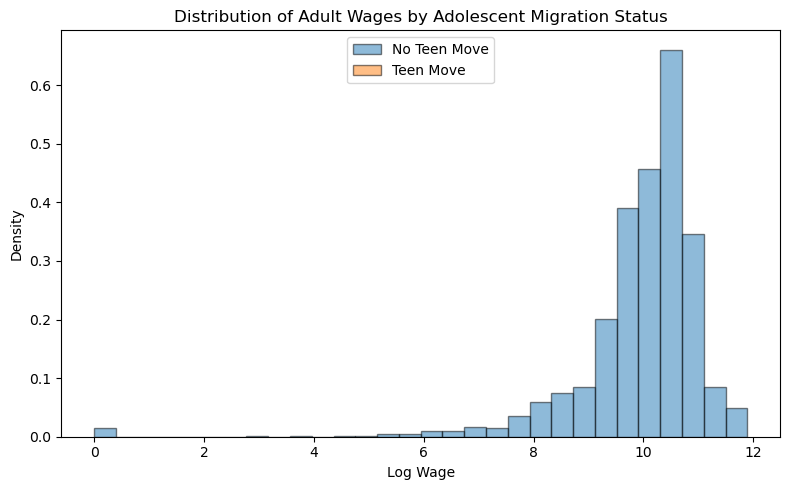

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.hist(
    df_ols[df_ols["teen_move"] == 0]["log_wage"],
    bins=30,
    density=True,
    alpha=0.5,
    label="No Teen Move",
    edgecolor="black"
)

plt.hist(
    df_ols[df_ols["teen_move"] == 1]["log_wage"],
    bins=30,
    density=True,
    alpha=0.5,
    label="Teen Move",
    edgecolor="black"
)

plt.xlabel("Log Wage")
plt.ylabel("Density")
plt.title("Distribution of Adult Wages by Adolescent Migration Status")
plt.legend()
plt.tight_layout()
plt.show()
